# 33 临时对象池sync.Pool
到目前为止，我们已经学习了Go语言标准库中最重要的几个同步工具，包括了非常经典的互斥锁，读写锁，条件变量和原子操作，以及Go语言特有的几个同步工具：
1. sync/atomic.Value
2. sync.Once
3. sync.WaitGroup
4. context.Context
今天，我们介绍标准库中另外一个同步工具：sync.Pool

`sync.Pool`类型可以被称为临时对象池，它的值可以被用来**存储临时的对象**。与Go语言的很多同步工具一样，`sync.Pool`类型也属于结构体类型，它的值在被真正使用之后，就不应该再被**复制**了。

这里的“临时对象”的意思是：不需要持久使用的某一类值。这类值对于程序来说可有可无，但如果有的话会明显更好。它们的创建和销毁可以在任何时候发生，并且完全不会影响到程序的功能。

同时，它们也应该是无需被区分的，其中的任何一个值都可以代替另一个。如果你的某类值完全满足上述条件，那么你就可以把它们存储到临时对象池中。

你可能已经想到了，我们可以把**临时对象池当作针对某种数据的缓存**来用。实际上，在我看来，临时对象池最主要的用途就在于此。

`sync.Pool`类型只有两个方法——`Put`和`Get`。`Put`用于在当前的池中存放临时对象，它接受一个`interface{}`类型的参数；而`Get`则被用于从当前的池中获取临时对象，它会返回一个`interface{}`类型的值。

更具体地说，这个类型的`Get`方法可能会从当前的池中删除掉任何一个值，然后把这个值作为结果返回。如果此时当前的池中没有任何值，那么这个方法就会使用当前池的`New`字段创建一个新值，并直接将其返回。

`sync.Pool`类型的`New`字段代表着创建临时对象的函数。它的类型是没有参数但有唯一结果的函数类型，即：`func() interface{}`。

这个函数是`Get`方法最后的临时对象获取手段。`Get`方法如果到了最后，仍然无法获取到一个值，那么就会调用该函数。该函数的结果值并不会被存入当前的临时对象池中，而是直接返回给`Get`方法的调用方。

这里的`New`字段的实际值需要我们在初始化临时对象池的时候就给定。否则，在我们调用它的`Get`方法的时候就有可能会得到`nil`。所以，`sync.Pool`类型并不是开箱即用的。不过，这个类型也就只有这么一个公开的字段，因此初始化起来也并不麻烦。

举个例子。标准库代码包`fmt`就使用到了`sync.Pool`类型。这个包会创建一个用于缓存某类临时对象的`sync.Pool`类型值，并将这个值赋给一个名为`ppFree`的变量。**这类临时对象可以识别、格式化和暂存需要打印的内容**。


In [ ]:
var ppFree = sync.Pool{
	New: func() interface{}{ return new(pp) },
}

# gonb_da1002ac 

 

 Cell[3]: Line 2 
 ./main.go:10:38: undefined: prettyPrinter
 

var (
	ppFree = sync.Pool{
 New: func() interface{}{ return new(prettyPrinter) },
 }
)

ERROR: failed to run "/usr/bin/go build -o /tmp/gonb_da1002ac/gonb_da1002ac": exit status 1

临时对象池`ppFree`的`New`字段在被调用的时候，总是会返回一个全新的`pp`类型值的指针（即临时对象）。这就保证了`ppFree`的`Get`方法总能返回一个可以包含需要打印内容的值。

`pp`类型是`fmt`包中的私有类型，它有很多实现了不同功能的方法。**不过，这里的重点是，它的每一个值都是独立的、平等的和可重用的**。注意这里针对的是每一个pp值。

> 更具体地说，这些对象既互不干扰，又不会受到外部状态的影响。它们几乎只针对某个需要打印内容的缓冲区而已。**由于fmt包中的代码在真正使用这些临时对象之前，总是会先对其进行重置**，所以它们并不在意取到的是哪一个临时对象。这就是临时对象的平等性的具体体现。

另外，这些代码在使用完临时对象之后，都会先抹掉其中已缓冲的内容，然后再把它存放到`ppFree`中。这样就为重用这类临时对象做好了准备。

众所周知的`fmt.Println`、`fmt.Printf`等打印函数都是如此使用`ppFree`，以及其中的临时对象的。因此，在程序同时执行很多的打印函数调用的时候，`ppFree`可以及时地把它缓存的临时对象提供给它们，以加快执行的速度。

而当程序在一段时间内不再执行打印函数调用时，`ppFree`中的临时对象又能够被及时地清理掉，以节省内存空间。

显然，在这个维度上，**临时对象池可以帮助程序实现可伸缩性**。这就是它的最大价值。

我想，到了这里你已经清楚了临时对象池的基本功能、使用方式、适用场景和存在意义。我们下面来讨论一下它的一些**内部机制**，这样，我们就可以更好地利用它做更多的事。

首先，我来问你一个问题。这个问题很可能也是你想问的。今天的问题是：**为什么说临时对象池中的值会被及时地清理掉**？

**这里的典型回答是：因为，`Go`语言运行时系统中的垃圾回收器，所以在每次开始执行之前，都会对所有已创建的临时对象池中的值进行全面地清除**。

## 问题解析

我在前面已经向你讲述了临时对象会在什么时候被创建，下面我再来详细说说它会在什么时候被销毁。

`sync`包在被初始化的时候，会向`Go`语言运行时**系统注册一个函数**，这个函数的功能就是清除所有已创建的临时对象池中的值。我们可以把它称为**池清理函数**。

一旦池清理函数被注册到了`Go`语言运行时系统，**后者在每次即将执行垃圾回收时就都会执行前者**。

另外，在`sync`包中还有一个**包级私有**的全局变量。**这个变量代表了当前的程序中使用的所有临时对象池的汇总，它是元素类型为`*sync.Pool`的切片**。我们可以称之为**池汇总列表**。

通常，在一个临时对象池的`Put`方法或`Get`方法第一次被调用的时候，这个池就会被添加到池汇总列表中。**意思就是这个池只要被使用了，就会被拖入池汇总列表中**正因为如此，池清理函数总是能访问到所有正在被真正使用的临时对象池。

更具体地说，池清理函数会遍历池汇总列表。对于其中的每一个临时对象池，它都会先将池中所有的私有临时对象和共享临时对象列表都置为`nil`，然后再把这个池中的所有本地池列表都销毁掉。

最后，池清理函数会把池汇总列表重置为空的切片。如此一来，这些池中存储的临时对象就全部被清除干净了。

如果临时对象池以外的代码再无对它们的引用，那么在稍后的垃圾回收过程中，这些临时对象就会被当作垃圾销毁掉，它们占用的内存空间也会被回收以备他用。

以上，就是我对临时对象清理的进一步说明。首先需要记住的是，池清理函数和池汇总列表的含义，以及它们起到的关键作用。一旦理解了这些，那么在有人问到你这个问题的时候，你应该就可以从容地应对了。

不过，我们在这里还碰到了几个新的词，比如：**私有临时对象、共享临时对象列表和本地池。**这些都代表着什么呢？这就涉及了下面的问题。

## 知识扩展
**问题一：临时对象池存储值所用的数据结构是怎样的？**
在临时对象池中，有一个**多层**的数据结构。正因为有了它的存在，临时对象池才能够非常高效地存储大量的值。

这个数据结构的顶层，我们可以称之为**本地池列表**，不过更确切地说，它是一个数组。这个列表的长度，总是与Go语言调度器中的P的数量相同。

还记得吗？**Go语言调度器中的P是processor的缩写，它指的是一种可以承载若干个G、且能够使这些G适时地与M进行对接，并得到真正运行的中介**。

这里的G正是goroutine的缩写，而M则是machine的缩写，后者指代的是系统级的线程。正因为有了P的存在，G和M才能够进行灵活、高效的配对，从而实现强大的并发编程模型。

P存在的一个很重要的原因是为了**分散并发程序**的执行压力，而让临时对象池中的本地池列表的长度与P的数量相同的主要原因也是分散压力。这里所说的压力包括了存储和性能两个方面。在说明它们之前，我们先来探索一下临时对象池中的那个数据结构。

在本地池列表中的每个本地池都包含了三个字段（或者说组件），它们是：存储私有临时对象的字段`private`、代表了共享临时对象列表的字段`shared`，以及一个`sync.Mutex`类型的嵌入字段。

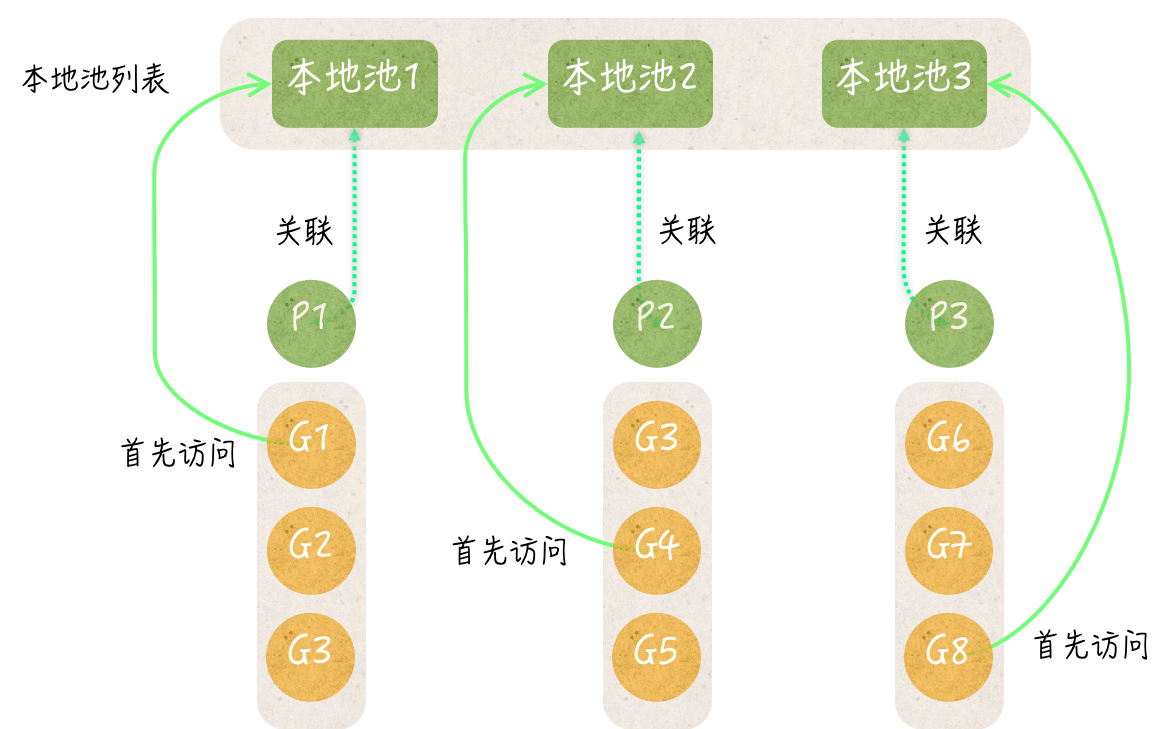

实际上，每个本地池都对应着一个P。我们都知道，一个goroutine要想真正运行就必须先与某个P产生关联。也就是说，一个正在运行的goroutine必然会关联着某个P。

在程序调用临时对象池的`Put`方法或`Get`方法的时候，总会先试图从该临时对象池的本地池列表中，获取与之对应的本地池，依据的就是与当前的`goroutine`关联的那个`P`的`ID`。

换句话说，一个临时对象池的`Put`方法或`Get`方法会获取到哪一个本地池，完全取决于调用它的代码所在的`goroutine`关联的那个P。

既然说到了这里，那么紧接着就会有下面这个问题。

**问题 2：临时对象池是怎样利用内部数据结构来存取值的**？

临时对象池的`Put`方法总会先试图把新的临时对象，存储到对应的本地池的`private`字段中，以便在后面获取临时对象的时候，可以快速地拿到一个可用的值。

只有当这个`private`字段已经存有某个值时，该方法才会去访问本地池的`shared`字段。

相应的，临时对象池的`Get`方法，总会先试图从对应的本地池的`private`字段处获取一个临时对象。只有当这个`private`字段的值为`nil`时，它才会去访问本地池的`shared`字段。

一个本地池的`shared`字段原则上可以被任何`goroutine`中的代码访问到，不论这个`goroutine`关联的是哪一个P。这也是我把它叫做共享临时对象列表的原因。

相比之下，一个本地池的`private`字段，只可能被与之对应的那个`P`所关联的`goroutine`中的代码访问到，所以可以说，**它是P级私有的**。

以临时对象池的`Put`方法为例，它一旦发现对应的本地池的`private`字段已存有值，就会去访问这个本地池的`shared`字段。当然，由于`shared`字段是共享的，所以此时必须受到互斥锁的保护。

还记得本地池嵌入的那个`sync.Mutex`类型的字段吗？它就是这里用到的互斥锁，也就是说，本地池本身就拥有互斥锁的功能。`Put`方法会在互斥锁的保护下，把新的临时对象追加到共享临时对象列表的末尾。

相应的，临时对象池的`Get`方法在发现对应本地池的`private`字段未存有值时，也会去访问后者的`shared`字段。它会在互斥锁的保护下，试图把该共享临时对象列表中的最后一个元素值取出并作为结果。

不过，这里的共享临时对象列表也可能是空的，这可能是由于这个本地池中的所有临时对象都已经被取走了，也可能是当前的临时对象池刚被清理过。

无论原因是什么，Get方法都会去访问当前的临时对象池中的所有本地池，它会去逐个搜索它们的共享临时对象列表。

只要发现某个共享临时对象列表中包含元素值，它就会把该列表的最后一个元素值取出并作为结果返回。
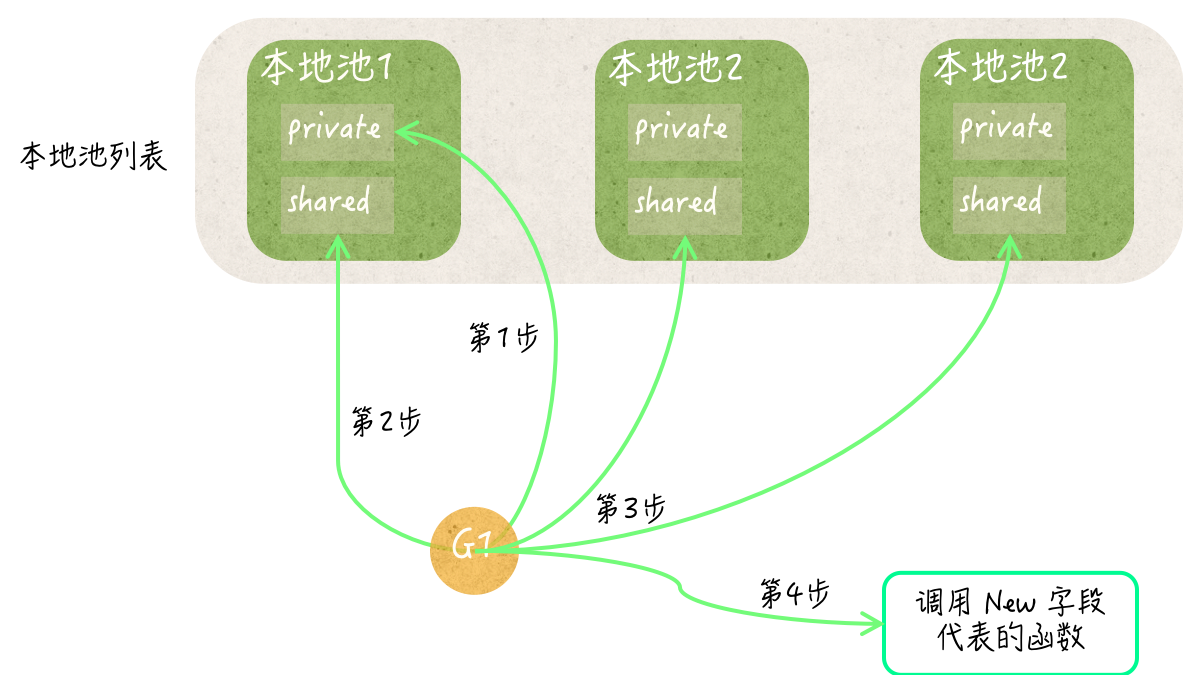

当然了，即使这样也可能无法拿到一个可用的临时对象，比如，在所有的临时对象池都刚被大清洗的情况下就会是如此。

这时，`Get`方法就会使出最后的手段——调用可创建临时对象的那个函数。还记得吗？这个函数是由临时对象池的`New`字段代表的，并且需要我们在初始化临时对象池的时候给定。如果这个字段的值是`nil`，那么`Get`方法此时也只能返回`nil`了。

以上，就是我对这个问题的较完整回答。

## 总结

今天，我们一起讨论了另一个比较有用的同步工具——`sync.Pool`类型，它的值被我称为临时对象池。

临时对象池有一个`New`字段，我们在初始化这个池的时候最好给定它。临时对象池还拥有两个方法，即：`Put`和`Get`，它们分别被用于向池中存放临时对象，和从池中获取临时对象。

临时对象池中存储的每一个值都应该是独立的、平等的和可重用的。我们应该既不用关心从池中拿到的是哪一个值，也不用在意这个值是否已经被使用过。

要完全做到这两点，可能会需要我们额外地写一些代码。不过，这个代码量应该是微乎其微的，就像`fmt`包对临时对象池的用法那样。所以，在选用临时对象池的时候，我们必须要把它将要存储的值的特性考虑在内。

在临时对象池的内部，有一个多层的数据结构支撑着对临时对象的存储。它的顶层是本地池列表，其中包含了与某个`P`对应的那些本地池，并且其长度与`P`的数量总是相同的。

在每个本地池中，都包含一个私有的临时对象和一个共享的临时对象列表。前者只能被其对应的`P`所关联的那个`goroutine`中的代码访问到，而后者却没有这个约束。从另一个角度讲，前者用于临时对象的快速存取，而后者则用于临时对象的池内共享。

正因为有了这样的数据结构，临时对象池才能够有效地分散存储压力和性能压力。同时，又因为临时对象池的`Get`方法对这个数据结构的妙用，才使得其中的临时对象能够被高效地利用。比如，该方法有时候会从其他的本地池的共享临时对象列表中，“偷取”一个临时对象。

这样的内部结构和存取方式，让临时对象池成为了一个特点鲜明的同步工具。它存储的临时对象都应该是拥有较长生命周期的值，并且，这些值不应该被某个`goroutine`中的代码长期的持有和使用。

因此，临时对象池非常适合用作针对某种数据的缓存。从某种角度讲，临时对象池可以帮助程序实现可伸缩性，这也正是它的最大价值。

## 思考题
今天的思考题是：怎样保证一个临时对象池中总有比较充足的临时对象？

请从临时对象池的初始化和方法调用两个方面作答。必要时可以参考`fmt`包以及demo70.go文件中使用临时对象池的方式。

答：首先，我们应该事先向临时对象池中放入足够多的临时对象。其次，在用完临时对象之后，我们需要及时地把它归还给临时对象池。

最后，我们应该保证它的New字段所代表的值是可用的。虽然New函数返回的临时对象**并不会被放入池**中，但是起码能够保证池的Get方法总能返回一个临时对象。